In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import quantstats as qs
import os


In [2]:
base_dir = os.getcwd()
print(base_dir)
file_path = os.path.abspath(os.path.join(base_dir, '..', 'data'))
print(file_path)

c:\Users\matth\codeProjects\union_sif_quant_trading\backtesting
c:\Users\matth\codeProjects\union_sif_quant_trading\data


In [3]:
stock_data = pd.read_parquet(file_path+'\\stock_price_data\\all_data_processed_2024-09-28_after_1990.parquet')
display(stock_data.info())
display(stock_data.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8752 entries, 1990-01-02 to 2024-09-27
Columns: 140640 entries, ('Adj_Close', 'AACG') to ('Size_Category', 'ZYXI')
dtypes: float64(134988), int64(30), object(5622)
memory usage: 9.2+ GB


None

Adj_Close                                                        \
                AACG   AACT  AAME    AAN        AAT  ABAT       ABCB  ABCL   
Date                                                                         
2024-09-23      0.63  10.80  1.58  10.06  27.120001  0.89  63.709999  2.48   
2024-09-24      0.68  10.81  1.59  10.06  27.320000  0.87  62.340000  2.52   
2024-09-25      0.73  10.80  1.56  10.03  27.040001  0.81  61.240002  2.44   
2024-09-26      0.72  10.81  1.61  10.03  26.490000  0.94  61.459999  2.56   
2024-09-27      0.73  10.83  1.68  10.05  26.570000  0.98  61.320000  2.61   

                               ... Size_Category                              \
                   ABG   ABTS  ...           ZTS   ZUMZ    ZUO   ZURA   ZVIA   
Date                           ...                                             
2024-09-23  227.949997  0.490  ...         large  small  small  small  micro   
2024-09-24  230.240005  0.500  ...         large  small  small  small  micro   
2024-09-25  231.699997  0.500  ...         large  small  small  micro  micro   
2024-09-26  238.210007  0.499  ...         large  small  small  small  micro   
2024-09-27  244.350006  0.513  ...         large  small  small  small  micro   

                                             
             ZVRA   ZVSA  ZWS   ZYME   ZYXI  
Date                                         
2024-09-23  small  micro  mid  small  small  
2024-09-24  small  micro  mid  small  small  
2024-09-25  small  micro  mid  small  small  
2024-09-26  small  micro  mid  small  small  
2024-09-27  small  micro  mid  small  small  

[5 rows x 140640 columns]

In [4]:
# read company data
company_data = pd.read_csv(file_path+'\\company_data\\company_data_cleaned_2024-09-29.csv',index_col=0)
company_data.head()

,Name,Last_Sale,Net_Change,Percent_Change,Market_Cap,Country,IPO_Year,Volume,Sector,Industry,Exchange
Ticker,,,,,,,,,,,
A,Agilent Technologies Inc. Common Stock,$148.06,1.3200,0.90%,4.254173e+10,United States,1999.0,2212993,Industrials,Biotechnology: Laboratory Analytical Instruments,NYSE
AA,Alcoa Corporation Common Stock,$39.27,-0.0100,-0.025%,1.014502e+10,United States,2016.0,5629158,Industrials,Aluminum,NYSE
AACG,ATA Creativity Global American Depositary Shares,$0.7302,0.0078,1.08%,2.336650e+07,China,2008.0,26100,Real Estate,Other Consumer Services,NASDAQ
AACT,Ares Acquisition Corporation II Class A Ordina...,$10.8299,0.0199,0.184%,0.000000e+00,NaN,2023.0,2476,Finance,Blank Checks,NYSE
AADI,Aadi Bioscience Inc. Common Stock,$1.93,0.0200,1.047%,4.750663e+07,United States,NaN,81024,Health Care,Biotechnology: Pharmaceutical Preparations,NASDAQ


In [5]:
# def select_data_subset(input_dataframe, std_dev_day_range='all', reg_day_range='all', ticker_subset='all', price_vars_to_exclude='none', start_date='none'):
#     """
#     Selects a subset of stock data based on a variety of factors.

#     Args:
#         input_dataframe (pandas dataframe, required): DataFrame with stock data.
#         std_dev_day_range (str, list, optional): Leave as 'all' to include everything, give an int or a list of ints to select only std_devs over that/those periods. Defaults to 'all'.
#         reg_day_range (list, optional): Leave as 'all' to include everything, give an int or a list of ints to select only reg values (intercept and coeffs) over that/those periods. Defaults to 'all'.
#         ticker_subset (list, optional): Leave as 'all' to include all tickers, or give a list of ticker(s) to keep. Defaults to 'all'.
#         price_vars_to_exclude (list, optional): Leave as 'none' to include all price vars, or give a list of price variables to exclude. Defaults to 'none'.
#         start_date (str, optional): The date before which you don't want data, in the format 'YYYY-MM-DD'. Defaults to 'none'.

#     Returns:
#         pandas dataframe: Filtered DataFrame based on the specified criteria.
#     """

#     # filter date
#     if start_date != 'none':
#         return_df = input_dataframe[input_dataframe.index > start_date]
#     else:
#         return_df = input_dataframe
    
#     return_cols = list(return_df.columns)

#     # filter tickers
#     if ticker_subset != 'all':
#         # print(return_cols)
#         return_cols = list(x for x in return_cols if x[1] in (ticker_subset+['']) )
    
#     # exclude price vars
#     if price_vars_to_exclude != 'none':
#         return_cols = list({x for x in return_cols if x[0] not in price_vars_to_exclude})
    
#     # filter std dev day ranges
#     if std_dev_day_range != 'all':
#         std_dev_day_range = tuple(str(x) for x in std_dev_day_range)
#         return_cols = list(
#             set(return_cols)
#             - set( list(x for x in return_cols if ( x[0].startswith('Std_Dev') and (not (x[0].endswith(std_dev_day_range))) )) )
#             )


#     # filter regression day ranges
#     if reg_day_range != 'all':
#         print()
#         bad_reg_cols = [
#             x for x in return_cols 
#             if (x[0].split('_')[0] == 'Intercept' or 
#                 (len(x[0].split('_')) > 1 and x[0].split('_')[-2] == 'Coeff') )
#                 ]
#         # print(bad_reg_cols)
#         # bad_reg_cols = {x for x in bad_reg_cols if any(a in x for a in reg_day_range)}
#         # print({x[0] for x in bad_reg_cols})
#         # print(bad_reg_cols[0:10])
#         bad_reg_cols = {x for x in bad_reg_cols if not any(str(a) in x[0] for a in reg_day_range)}
#         # print({x[0] for x in bad_reg_cols})
#         return_cols = list(set(return_cols) - set(bad_reg_cols))

#     #     reg_day_range = tuple(str(x) for x in reg_day_range)
#     #     print(return_cols[-10:])
#     #     return_cols = list(
#     #         set(return_cols)
#     #         - set( x for x in return_cols if 
#     #             #   ((x[0].startswith('Intercept_') or x[0].split('_')[-2]=='Coeff') and (not x[0].endswith(reg_day_range))))
#     #               ((x[0].split('_')[0]=='Intercept' or x[0].split('_')[-2]=='Coeff') and (not x[0].endswith(reg_day_range))))
#     #     )

#     # filter regression day ranges
#     # if reg_day_range != 'all':
#     #     reg_day_range = tuple(str(x) for x in reg_day_range)
#     #     print(return_cols[-10:])
#     #     return_cols = list(
#     #         set(return_cols)
#     #         - set( x for x in return_cols if 
#     #             #   ((x[0].startswith('Intercept_') or x[0].split('_')[-2]=='Coeff') and (not x[0].endswith(reg_day_range))))
#     #               ((x[0].split('_')[0]=='Intercept' or x[0].split('_')[-2]=='Coeff') and (not x[0].endswith(reg_day_range))))
#     #     )
    
#     if not((ticker_subset == 'all') and (price_vars_to_exclude =='none') and (std_dev_day_range=='all') and (reg_day_range=='all')):
#         return_df = return_df[return_cols]

#     return(return_df)


In [6]:
# def add_lin_reg_prediction(df, reg_range, predict_target_day=0, new_multiindex_col_name=None):
#     """adds a linear regression prediction using existing coefficients and intercepts

#     Args:
#         df (dataframe, required): the dataframe that holds the data
#         reg_range (int, required): one of the ranges that regressions exist over in the dataframe
#         predict_target (int, optional): the target of the prediction relative to the column. 0 will be that day, 5 will be 5 trading days into the future. Defaults to 0.
#         new_multiindex_col_name (str, optional): add a string you want as the multi index title in index 0 of the column name, or leave as None to return non-multi index dataframe. Defaults to None.
    
#     Returns:
#         pandas dataframe with only the regression prediction values
#     """

#     # the column that holds the intercept for the regression
#     intercept_col = 'Intercept_'+str(reg_range)

#     # a list of columns with the coefficients
#     coeff_cols = list({x[0] for x in df.columns if(
#         x[0].endswith(str(reg_range)) and
#         x[0].split('_')[-2]=='Coeff'
#     )})

#     # a list of columns with what the coeffients are to be multiplied by
#     predictor_cols = list({ ('_'.join(x.split('_')[0:-2])) for x in coeff_cols})

#     coeff_cols_dict = {}
#     for coeff in coeff_cols:
#         # get predictor name
#         predictor_name = '_'.join(coeff.split('_')[:-2])
        
#         # checks if there is an error in the naming system- better to throw an error than have wrong data
#         if predictor_name in predictor_cols:
#             coeff_cols_dict[predictor_name] = coeff
#         else: 
#             exit("column names are fucked up, a predictor_col doesn't")
    
#     del(coeff_cols)

#     # intercept
#     return_df = df.xs(intercept_col, axis=1,level=0)

#     # plus coefficient* value for each coeficient value pair (for multivar regressions)
#     for p_col in predictor_cols:
#         return_df = return_df + (df.xs(p_col,axis=1,level=0).values *df.xs(coeff_cols_dict[p_col], axis=1, level =0))
    
#     if new_multiindex_col_name == None:
#         return(return_df.apply(pd.to_numeric, errors='coerce'))
#     else: 
#         new_columns = pd.MultiIndex.from_product([[new_multiindex_col_name], return_df.columns])
#         return_df.columns= new_columns
#         return(return_df.apply(pd.to_numeric, errors='coerce'))

In [7]:
# def add_price_diff_metric(df, actual_val_col, theo_val_col, std_dev_col, new_multiindex_col_name=None):
#     """returns dataframe with difference between theoretical value and actual price in terms of a value

#     Args:
#         df (pandas dataframe): source dataframe
#         actual_val_col (str): the name of the column of the actual price value eg 'Adj_Close'"date_numbers copy.py"
#         theo_val_vol (str): the name of the column of the predicted theoretical price 
#         std_dev_col (str): the name of the column of standard deviation you want the difference in terms of
#         new_multiindex_col_name (str, optional): add a string you want as the multi index title in index 0 of the column name, or leave as None to return non-multi index dataframe. Defaults to None.

#     """
    

#     return_df = df.xs(theo_val_col, axis=1, level=0)
#     return_df = return_df - df.xs(actual_val_col, axis=1, level=0)
#     return_df = return_df/ df.xs(std_dev_col, axis=1, level=0)

#     if new_multiindex_col_name == None:
#         return(return_df)
#     else: 
#         new_columns = pd.MultiIndex.from_product([[new_multiindex_col_name], return_df.columns])
#         return_df.columns = new_columns
#         return(return_df)


In [8]:
from data_interaction import select_data_subset, add_lin_reg_prediction, add_price_diff_metric

In [9]:
stock_data = select_data_subset(
    input_dataframe=stock_data,
    std_dev_day_range=[30, 60],
    reg_day_range=[30, 60],
    # ticker_subset=['AAPL', 'CMI', 'SLB'],
    price_vars_to_exclude=['Open','Close','High','Low'],
    start_date='1993-06-01'
)
display(stock_data.info())
display(stock_data)



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7888 entries, 1993-06-02 to 2024-09-27
Columns: 61319 entries, ('Volume', 'MSD') to ('Market_Cap', 'PAAS')
dtypes: float64(55667), int64(30), object(5622)
memory usage: 3.6+ GB


None

Volume Std_Dev_30           Intercept_60 Intercept_30   Volume  \
                 MSD       HTBK      LCID          CNP          API    HTOOW   
Date                                                                           
1993-06-02       NaN        NaN       NaN    -1.057200          NaN      NaN   
1993-06-03       NaN        NaN       NaN    -1.187449          NaN      NaN   
1993-06-04       NaN        NaN       NaN    -1.386903          NaN      NaN   
1993-06-07       NaN        NaN       NaN    -1.558228          NaN      NaN   
1993-06-08       NaN        NaN       NaN    -1.736530          NaN      NaN   
...              ...        ...       ...          ...          ...      ...   
2024-09-23  146600.0   0.234857  0.357977   347.774185   271.394452  56500.0   
2024-09-24   71800.0   0.230604  0.350032   307.190363   271.227770    400.0   
2024-09-25   57800.0   0.213328  0.322352   266.958256   271.053163   1900.0   
2024-09-26  112300.0   0.205409  0.306591   231.628005   270.865683   6100.0   
2024-09-27   66400.0   0.193169  0.290688   193.474371   270.637263   8000.0   

              Market_Cap Intercept_30 Dates_Numeric_Coeff_60  \
                    PLSE        SOHOO                   FITB   
Date                                                           
1993-06-02           NaN          NaN               0.001052   
1993-06-03           NaN          NaN               0.001051   
1993-06-04           NaN          NaN               0.001051   
1993-06-07           NaN          NaN               0.001050   
1993-06-08           NaN          NaN               0.001048   
...                  ...          ...                    ...   
2024-09-23  1.061548e+09    23.194133               0.002485   
2024-09-24  1.050516e+09    23.206717               0.002492   
2024-09-25  1.037645e+09    23.219386               0.002498   
2024-09-26  1.035193e+09    23.232045               0.002504   
2024-09-27  1.054500e+09    23.219660               0.002509   

           Dates_Numeric_Coeff_30  ...    Volume Intercept_30 Size_Category  \
                              UNM  ...      OBLG         INFA          BBCP   
Date                               ...                                        
1993-06-02               0.004663  ...       NaN          NaN          None   
1993-06-03               0.004671  ...       NaN          NaN          None   
1993-06-04               0.004675  ...       NaN          NaN          None   
1993-06-07               0.004674  ...       NaN          NaN          None   
1993-06-08               0.004666  ...       NaN          NaN          None   
...                           ...  ...       ...          ...           ...   
2024-09-23               0.003751  ...  197300.0    91.910788         small   
2024-09-24               0.003762  ...  127300.0    91.316660         small   
2024-09-25               0.003771  ...  286400.0    90.704965         small   
2024-09-26               0.003780  ...  174900.0    90.281594         small   
2024-09-27               0.003789  ...   55900.0    89.734648         small   

           Std_Dev_60 Dates_Numeric_Coeff_60 Size_Category   Volume  \
                   CL                     ZD          IPXX    DCOMP   
Date                                                                  
1993-06-02   0.189261                    NaN          None      NaN   
1993-06-03   0.191679                    NaN          None      NaN   
1993-06-04   0.194438                    NaN          None      NaN   
1993-06-07   0.199584                    NaN          None      NaN   
1993-06-08   0.207626                    NaN          None      NaN   
...               ...                    ...           ...      ...   
2024-09-23   3.738381               0.004642         small  19800.0   
2024-09-24   3.717305               0.004633         small  10900.0   
2024-09-25   3.676489               0.004622         small   6900.0   
2024-09-26   3.592308               0

In [10]:
# magic_number = str(30)
# theo_var = 'Lin_Reg_60_Pred_0' #'Lin_Reg_Pred_' + magic_number
# std_dev_var = 'Std_Dev_30' #'Std_Dev_' + magic_number + '_Day'
# price_diff_var = 'delta_60pred_by_30std' #'Price_Diff_' + magic_number
# how_old_to_sell = 120
# how_many_poss = 30
# del(magic_number)

In [11]:
# magic_number = str(30)
# theo_var = 'Lin_Reg_60_Pred_0'#'Lin_Reg_Pred_' + magic_number
# std_dev_var = 'Std_Dev_30' #'Std_Dev_' + magic_number + '_Day'
# price_diff_var = 'delta_60pred_by_30std'#'Price_Diff_' + magic_number
# how_old_to_sell = 120
# how_many_poss = 30
# del(magic_number)

# class Position:
#     def __init__(self, date_opened, ticker, shares):
#         self.date_opened = date_opened
#         self.ticker = ticker
#         self.shares = shares
#         self.cost_basis = shares*stock_data.at[date_opened,('Adj_Close',ticker)]
#         self._current_value = shares*stock_data.at[date_opened,('Adj_Close',ticker)]
#         self._current_theo = shares*stock_data.at[date_opened,(theo_var,ticker)]
#         self._current_std_dev = shares*stock_data.at[date_opened,(std_dev_var,ticker)]
#         self._current_price_diff = stock_data.at[date_opened,(price_diff_var,ticker)]
#         self._last_date_checked = date_opened

#     def __repr__(self):
#         return (f"Position(date_opened={self.date_opened}, ticker='{self.ticker}', "
#                 f"shares={self.shares}, cost_basis={self.cost_basis}, "
#                 f"current_value={self._current_value}, "
#                 f"current_theo={self._current_theo}, "
#                 f"current_std_dev={self._current_std_dev}, "
#                 f"current_price_diff={self._current_price_diff}),"
#                 f"last_date_checked={self._last_date_checked}")

#     def get_ticker(self):
#         return(self.ticker)
    
#     def days_old(self, date:str):
#         """returns the number of days old a position is

#         Args:
#             date (str): date formated 'YYYY-MM-DD'
#         """
#         if type(self.date_opened) == str:
#             opened = datetime.datetime.strptime(self.date_opened, '%Y-%m-%d').date()
#         else:
#             opened = self.date_opened
#         if type(date)==str:
#             current = datetime.datetime.strptime(date, '%Y-%m-%d').date()
#         else:
#             current = date
#         return((current-opened).days)
    
#     def __refresh__(self,current_date):
#         self._last_date_checked = current_date
#         self._current_value = self.shares*stock_data.at[current_date,('Adj_Close',self.ticker)]
#         self._current_theo = stock_data.at[current_date,(theo_var, self.ticker)]
#         self._current_std_dev = stock_data.at[current_date,(theo_var, self.ticker)]
#         self._current_price_diff = stock_data.at[current_date,(price_diff_var, self.ticker)]
#         # recalculate current_value as well as all other values that change over time,
#         pass

#     def get_current_value(self, current_date):
#         self.__refresh__(current_date=current_date)
#         return(self._current_value)
    
#     def get_current_theo(self, current_date):
#         self.__refresh__(current_date=current_date)
#         return(self._current_theo)
    
#     def get_current_std_dev(self, current_date):
#         self.__refresh__(current_date=current_date)
#         return(self._current_std_dev)

#     def get_current_price_diff(self, current_date):
#         self.__refresh__(current_date=current_date)
#         return(self._current_price_diff)


In [12]:
# class Portfolio:
#     def __init__(self, cash: float, date, trading_cost =0.005):
#         """create portfolio object

#         Args:
#             cash (float): starting amount of cash in account
#             date (_type_): starting date
#             trading_cost (float, optional): cost of trading- each time we transact, we lose this amount. Defaults to 0.005.
#         """
#         self.position_df = pd.DataFrame(columns=['Position', 'Exposure', 'Value', 'Date_Opened', 'Days_Old'])
#         self.position_df.index.name = 'Ticker'
#         # Ensure 'Value' is explicitly set to float type
#         self.position_df.loc['cash_position'] = ['N/A', 'N/A', float(cash), date, 0]  # Cast cash to float
#         self.position_df = self.position_df.astype({'Value': 'float64'})  # Ensure Value column remains float
#         self._last_date_checked = date
#         self.trading_cost = trading_cost
#         # log portfolio opening
#         # logger.info(f'Portfolio opened on {date}')
    
#     # def __repr__(self):
#     #     returnString = f"Current Portfolio Value: {self.get_portfolio_value(self._last_date_checked)}\n"
#     #     returnString += f"Cash: {self.position_df.loc['cash_position', 'Value']}\n"
#     #     for pos in self.position_df['Position']:
#     #         returnString += repr(pos)
#     #     return returnString
        
#     def get_cash(self):
#         """returns size of cash_position
#         """
#         return(self.position_df.at['cash_position','Value'])

#     def get_exposure(self):
#         exposure = self.position_df['Value'].iloc[1:].sum()
#         return(exposure)

#     def position_count(self):
#         return(len(self.position_df.index)-1)
    
#     def open_position(self, position):
#         # Assuming position has attributes `cost_basis`, `get_ticker()`, and `date_opened`
#         if position.cost_basis > self.position_df.loc['cash_position', 'Value']:
#             print('Position not opened; too expensive')
#             print(f"Available cash: {self.position_df.loc['cash_position', 'Value']}\nPosition cost: {position.cost_basis}")
#         else:
#             # Explicit cast to ensure correct dtype when modifying Value
#             self.position_df.loc['cash_position', 'Value'] = float(self.position_df.loc['cash_position', 'Value']) - (position.cost_basis * (1+self.trading_cost))
#             # Add new row for the position
#             self.position_df.loc[position.get_ticker()] = [position, position.shares, position.cost_basis, position.date_opened, 0]
#             # log purchase
    
#     def close_position(self, ticker: str, current_date: str):
#         """close a currently open position"""
#         self._last_date_checked = current_date
#         if ticker == 'cash_position':
#             print('Cannot sell cash position')
#         else:
#             position_value = self.position_df.loc[ticker, 'Position'].get_current_value(current_date)
#             self.position_df.loc['cash_position', 'Value'] += (position_value * (1-self.trading_cost))
#             self.position_df.drop(index=ticker, inplace=True)
#             # log sale
    
#     def get_portfolio_value(self, date):
#         """gets the value of all the positions in the portfolio on the given date"""
#         self.refresh_position_df(date)
#         self._last_date_checked = date
#         value = 0
#         for ticker in self.position_df.index:
#             value += self.position_df.loc[ticker, 'Value']
#         return value
    
#     def refresh_position_df(self, date):
#         self._last_date_checked = date
#         for ticker in self.position_df.index[1:]:  # Skipping the cash position
#             self.position_df.loc[ticker, 'Value'] = self.position_df.loc[ticker, 'Position'].get_current_value(date)
#             self.position_df.loc[ticker,'Days_Old'] = self.position_df.loc[ticker, 'Position'].days_old(date)

#     def to_string(self, date: str):
#         """returns a string summarizing portfolio's value"""
#         self.refresh_position_df(date)
#         return_string = f"Current Portfolio Value: {self.get_portfolio_value(date)}\n"
#         return_string += f"Cash: {self.position_df.loc['cash_position', 'Value']}\n"
#         for ticker in self.position_df.index[1:]:
#             return_string += repr(self.position_df.loc[ticker, 'Position']) +'\n'
#         return return_string


In [13]:
from stock_picking import best_on_date


# def best_on_date(stock_data:pd.DataFrame,date:str,metric:str,abs_val:bool=True,how_many:int=1, max_or_min = 'max',exclude_extremes=True, min_trading_volume=10000, min_trading_volume_value=100000, size_categories=['mega','large','mid','small','micro'], min_market_cap=0):
#     """gets the ticker(s) of the best stock or stocks on a specific
#     date according to the numerical value of either a specific metric,
#     or the absolute value of a specific metric. If there is not enough tickers with data then the
#     return value will be None and a warning will be printed and logged

#     Args:
#         stock_data (pd.DataFrame): the dataframe to use for reference
#         date (str): date in the format of 'YYYY-MM-DD'
#         metric (str): the name of the column to be used for evaluation
#         abs_val (bool, optional): do you want the highest values in the column, or the values furthest from 0. Defaults to True.
#         how_many (int, optional): top __ ticker(s). Defaults to 1.
#     """

#     # takes a slice of dataframe for current date with .xs(date)
#     # unstack if because .xs puts it in long format
#     # transpose so tickers are the index column
#     date_slice = stock_data.xs(date).unstack().transpose()

#     # numeric_cols = date_slice.select_dtypes(include=['float', 'int']).columns
#     # date_slice[numeric_cols] = date_slice[numeric_cols].apply(pd.to_numeric, errors='coerce')
#     # date_slice[metric] = pd.to_numeric(date_slice[metric], errors='coerce')
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore", category=RuntimeWarning)
#         warnings.simplefilter("ignore", category=FutureWarning)
#         date_slice[metric] = pd.to_numeric(date_slice[metric], errors='coerce')


#     # simplify to just relevant data and drop na columns so we don't return useless data
#     date_slice = date_slice[date_slice['Market_Cap']>min_market_cap]
#     date_slice = date_slice[date_slice['Size_Category'].isin(size_categories)]
#     date_slice = date_slice[date_slice['Volume']>min_trading_volume]
#     date_slice = date_slice[date_slice['Volume_Value']>min_trading_volume_value]
#     date_slice = date_slice.filter(items=['Adj_Close', 'Volume', metric]).dropna()
#     # date_slice = date_slice.query(abs(metric)<100)# excludes extremes
#     date_slice = date_slice[np.abs(date_slice[metric])<50]
    
       

#     # if there is not enough data to return the number of tickers wanted, returns 
#     if len(date_slice.index)<how_many:
#         warningString = f"Warning: not enough data on {date} to run best_on_date. There is only {len(date_slice.index)} non-NaN values in {metric} but you want the top {how_many}. Returning {None}"
#         warnings.warn(warningString)
#         # logger.warning(warningString)
#         return(None)
#     else:
#         if max_or_min =='max':
#             if(abs_val):
#                 # gets the id (Tickers) of the 2 highest absolute value for price_diff_var
#                 max_tickers = abs(date_slice).nlargest(how_many,[metric]).index.tolist()
#             else:
#                 # gets the id (Tickers) of the 2 highest value for price_diff_var
#                 max_tickers = date_slice.nlargest(how_many,[metric]).index.tolist()
#             return(max_tickers)
#         if max_or_min == 'min':
#             if(abs_val):
#                 # gets the id (Tickers) of the 2 highest absolute value for price_diff_var
#                 min_tickers = abs(date_slice).nsmallest(how_many,[metric]).index.tolist()
#             else:
#                 # gets the id (Tickers) of the 2 highest value for price_diff_var
#                 min_tickers = date_slice.nsmallest(how_many,[metric]).index.tolist()
#             return(min_tickers)

In [14]:
pred_df_30 = add_lin_reg_prediction(stock_data, 30, new_multiindex_col_name='Lin_Reg_30_Pred_0')
pred_df_60 = add_lin_reg_prediction(stock_data, 60, new_multiindex_col_name='Lin_Reg_60_Pred_0')

stock_data = pd.concat([stock_data, pred_df_30, pred_df_60],axis=1)

stock_data = pd.concat([ stock_data, 
                           add_price_diff_metric(stock_data, 'Adj_Close','Lin_Reg_60_Pred_0', 'Std_Dev_30', 'delta_60pred_by_30std')
                           ], axis=1)

# adds volume value
price_df = stock_data.xs('Adj_Close',axis=1,level=0)
volume_df = stock_data.xs('Volume',axis=1,level=0)
volume_value_df = price_df*volume_df
new_columns = pd.MultiIndex.from_product([['Volume_Value'], volume_value_df.columns])
volume_value_df.columns = new_columns
# display(volume_value_df)
stock_data = pd.concat([stock_data,volume_value_df],axis=1)
print(list({x[0] for x in stock_data.columns}))
display(stock_data.info())
display(stock_data)



['Dates_Numeric', 'delta_60pred_by_30std', 'Lin_Reg_60_Pred_0', 'Intercept_60', 'Dates_Numeric_Coeff_60', 'Volume', 'Lin_Reg_30_Pred_0', 'Adj_Close', 'Market_Cap', 'Size_Category', 'Intercept_30', 'Std_Dev_60', 'Volume_Value', 'Dates_Numeric_Coeff_30', 'Std_Dev_30']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7888 entries, 1993-06-02 to 2024-09-27
Columns: 85977 entries, ('Volume', 'MSD') to ('Volume_Value', 'ZYXI')
dtypes: float64(80325), int64(30), object(5622)
memory usage: 5.1+ GB


None

Volume Std_Dev_30           Intercept_60 Intercept_30   Volume  \
                 MSD       HTBK      LCID          CNP          API    HTOOW   
Date                                                                           
1993-06-02       NaN        NaN       NaN    -1.057200          NaN      NaN   
1993-06-03       NaN        NaN       NaN    -1.187449          NaN      NaN   
1993-06-04       NaN        NaN       NaN    -1.386903          NaN      NaN   
1993-06-07       NaN        NaN       NaN    -1.558228          NaN      NaN   
1993-06-08       NaN        NaN       NaN    -1.736530          NaN      NaN   
...              ...        ...       ...          ...          ...      ...   
2024-09-23  146600.0   0.234857  0.357977   347.774185   271.394452  56500.0   
2024-09-24   71800.0   0.230604  0.350032   307.190363   271.227770    400.0   
2024-09-25   57800.0   0.213328  0.322352   266.958256   271.053163   1900.0   
2024-09-26  112300.0   0.205409  0.306591   231.628005   270.865683   6100.0   
2024-09-27   66400.0   0.193169  0.290688   193.474371   270.637263   8000.0   

              Market_Cap Intercept_30 Dates_Numeric_Coeff_60  \
                    PLSE        SOHOO                   FITB   
Date                                                           
1993-06-02           NaN          NaN               0.001052   
1993-06-03           NaN          NaN               0.001051   
1993-06-04           NaN          NaN               0.001051   
1993-06-07           NaN          NaN               0.001050   
1993-06-08           NaN          NaN               0.001048   
...                  ...          ...                    ...   
2024-09-23  1.061548e+09    23.194133               0.002485   
2024-09-24  1.050516e+09    23.206717               0.002492   
2024-09-25  1.037645e+09    23.219386               0.002498   
2024-09-26  1.035193e+09    23.232045               0.002504   
2024-09-27  1.054500e+09    23.219660               0.002509   

           Dates_Numeric_Coeff_30  ...  Volume_Value                \
                              UNM  ...           ZTS          ZUMZ   
Date                               ...                               
1993-06-02               0.004663  ...           NaN           NaN   
1993-06-03               0.004671  ...           NaN           NaN   
1993-06-04               0.004675  ...           NaN           NaN   
1993-06-07               0.004674  ...           NaN           NaN   
1993-06-08               0.004666  ...           NaN           NaN   
...                           ...  ...           ...           ...   
2024-09-23               0.003751  ...  2.547064e+08  7.684122e+06   
2024-09-24               0.003762  ...  3.961154e+08  5.761600e+06   
2024-09-25               0.003771  ...  3.651136e+08  5.397345e+06   
2024-09-26               0.003780  ...  3.032372e+08  5.384998e+06   
2024-09-27               0.003789  ...  2.617662e+08  5.775000e+06   

                                                                     \
                     ZUO          ZURA           ZVIA          ZVRA   
Date                                                                  
1993-06-02           NaN           NaN            NaN           NaN   
1993-06-03           NaN           NaN            NaN           NaN   
1993-06-04           NaN           NaN            NaN           NaN   
1993-06-07           NaN           NaN            NaN           NaN   
1993-06-08           NaN           NaN            NaN           NaN   
...                  ...           ...            ...           ...   
2024-09-23  9.765792e+06  5.381460e+06  121220.002627  1.818669e+07   
2024-09-24  6.546320e+06  1.614000e+06  130540.006399  2.047156e+07   
2024-09-25  9.717246e+06  7.163120e+05  330747.005129  1.784845e+07   
2024-09-26  8.135578e+06  7.189670e+05  176903.993511  6.633825e+06   
2024-09-27  1.135437e+07  1.600731e+06   80597.998989  1.148443e+07   

                    

In [15]:
from trading_classes import Position, Portfolio

In [16]:
list_of_dates = stock_data.index
list_of_dates

DatetimeIndex(['1993-06-02', '1993-06-03', '1993-06-04', '1993-06-07',
               '1993-06-08', '1993-06-09', '1993-06-10', '1993-06-11',
               '1993-06-14', '1993-06-15',
               ...
               '2024-09-16', '2024-09-17', '2024-09-18', '2024-09-19',
               '2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25',
               '2024-09-26', '2024-09-27'],
              dtype='datetime64[ns]', name='Date', length=7888, freq=None)

In [17]:
start_date = '2020-01-01'
list_of_dates = list_of_dates[list_of_dates>=start_date]
list_of_dates

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2024-09-16', '2024-09-17', '2024-09-18', '2024-09-19',
               '2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25',
               '2024-09-26', '2024-09-27'],
              dtype='datetime64[ns]', name='Date', length=1193, freq=None)

In [18]:
magic_number = str(30)
theo_var = 'Lin_Reg_60_Pred_0' #'Lin_Reg_Pred_' + magic_number
std_dev_var = 'Std_Dev_30' #'Std_Dev_' + magic_number + '_Day'
price_diff_var = 'delta_60pred_by_30std' #'Price_Diff_' + magic_number
how_old_to_sell = 135
how_many_poss = 10
del(magic_number)

In [55]:
# reimport a library
import importlib
import trading_classes
importlib.reload(trading_classes)
from trading_classes import Position, Portfolio

In [56]:
import trading_history
importlib.reload(trading_history)
from trading_history import Trading_History

In [57]:
trading_history_obj = Trading_History(stock_data,company_data)

In [58]:
portfolio_starting_capital = 10000
my_portfolio = Portfolio(portfolio_starting_capital, list_of_dates[0], stock_data,
                         theo_var, std_dev_var, price_diff_var,company_data=company_data, trading_history_obj=trading_history_obj)
print(my_portfolio.position_df)

              Position Exposure    Value Date_Opened  Days_Old
Ticker                                                        
cash_position      N/A      N/A  10000.0  2020-01-02         0


In [59]:
print(f"std_dev_var: {std_dev_var}")
print(f"theo_var: {theo_var}")
print(f"price_diff_var: {price_diff_var}")
print(f"how_old_to_sell: {how_old_to_sell}")
print(f"how_many_poss: {how_many_poss}")

std_dev_var: Std_Dev_30
theo_var: Lin_Reg_60_Pred_0
price_diff_var: delta_60pred_by_30std
how_old_to_sell: 135
how_many_poss: 10


In [60]:
historical_performance = pd.DataFrame(columns=['Portfolio_Value'])
historical_performance.index.name = 'Date'

In [61]:
stock_data.xs('Size_Category',1,0).stack().value_counts()

small    8017638
micro    5817673
mid      4748922
large    2869417
mega      209857
Name: count, dtype: int64

In [62]:
how_many_poss = how_many_poss
how_many_total = how_many_poss*2
how_many_rev = how_many_poss
how_many_mom = how_many_poss

how_old_to_sell = how_old_to_sell
short_position_wiggle_room = 1.2
for date in list_of_dates:
    clear_output(wait=True)
    my_portfolio.refresh_position_df(date)
    # any positions to sell
    tickers_to_sell = my_portfolio.position_df[my_portfolio.position_df['Days_Old'] >= how_old_to_sell].index.tolist()
    historical_performance.loc[date] = my_portfolio.get_portfolio_value(date)
    if (len(tickers_to_sell)>0):
        print(f"cash on hand: {my_portfolio.get_cash()}")
        print(f"tickers_to_sell: {tickers_to_sell}")
        for tts in tickers_to_sell:
            # historical_trades.loc[date] = [tts, my_portfolio.position_df.loc[tts,'Exposure'], None, my_portfolio.position_df.loc[tts,'Position'].get_current_value(date)]
            my_portfolio.close_position(tts,date)
        tickers_to_sell=0
        
    if(my_portfolio.position_count()<how_many_total):
        positions_we_want_rev = best_on_date(stock_data=stock_data,date=date,metric=price_diff_var,abs_val=False,how_many=how_many_rev,max_or_min='max',size_categories=['mid'], min_market_cap=100000)
        positions_we_want_mom = best_on_date(stock_data=stock_data,date=date,metric=price_diff_var,abs_val=False,how_many=how_many_mom,max_or_min='min',size_categories=['micro'], min_market_cap=100000)
        # (position_size cash - (value of short positions)*(short_position_wiggle_room)) / how many positions we plan on opening
        position_size = (my_portfolio.get_cash() + my_portfolio.position_df.query('Value < 0')['Value'].sum()*short_position_wiggle_room) / (how_many_total-my_portfolio.position_count())
        print(f"position_size: {position_size}")
        print(f"portfolio_value: {my_portfolio.get_portfolio_value(date)}")
        print(f"positions_we_want_mom: {positions_we_want_mom}")
        print(f"positions_we_want_rev: {positions_we_want_rev}")
        positions_we_want = positions_we_want_mom+positions_we_want_rev
        # open positions
        # get data on the positions we want
        relevant_data_rev = stock_data.xs(date).unstack().transpose().loc[positions_we_want_rev,['Adj_Close','Market_Cap','Size_Category',price_diff_var,std_dev_var,theo_var,'Volume','Volume_Value']]
        relevant_data_mom = stock_data.xs(date).unstack().transpose().loc[positions_we_want_mom,['Adj_Close','Market_Cap','Size_Category',price_diff_var,std_dev_var,theo_var,'Volume','Volume_Value']]
        relevant_data_rev['Strategy'] = 'Mean_Reversion'
        relevant_data_mom['Strategy'] = 'Momentum'
        relevant_data = pd.concat([relevant_data_mom,relevant_data_rev],axis=0)
        for ticker in positions_we_want:
            # last part makes desired shares negative if we expect stock to go down
                # *1.03 gives us wiggle room for slippage
            if relevant_data.loc[ticker,'Strategy']=='Mean_Reversion':
                relevant_data.loc[ticker,'Desired_Shares'] = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                # make sure we're not trading more than 3% of the trading volume 
                relevant_data['Desired_Shares'] = np.minimum(abs(relevant_data['Desired_Shares']), 0.08 * relevant_data['Volume']) * (relevant_data['Desired_Shares']/abs(relevant_data['Desired_Shares'])) # last part accounts for shorting

                # make it momentum instead of mean reversion
                # relevant_data.loc[ticker,'Desired_Shares'] *= -1
                relevant_data['Desired_Shares'] = relevant_data['Desired_Shares'].fillna(0)


                # historical_trades.loc[date] = [tts, my_portfolio.position_df.loc[tts,'Exposure'], my_portfolio.position_df.loc[tts,'Position'].get_current_value(date),None]
                my_portfolio.open_position(date,ticker, relevant_data.at[ticker,'Desired_Shares'])

            
            if relevant_data.loc[ticker,'Strategy']=='Momentum':
                relevant_data.loc[ticker,'Desired_Shares'] = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                # make sure we're not trading more than 3% of the trading volume 
                relevant_data['Desired_Shares'] = np.minimum(abs(relevant_data['Desired_Shares']), 0.08 * relevant_data['Volume']) * (relevant_data['Desired_Shares']/abs(relevant_data['Desired_Shares'])) # last part accounts for shorting

                # make it momentum instead of mean reversion
                relevant_data.loc[ticker,'Desired_Shares'] *= -1
                relevant_data['Desired_Shares'] = relevant_data['Desired_Shares'].fillna(0)


                # historical_trades.loc[date] = [tts, my_portfolio.position_df.loc[tts,'Exposure'], my_portfolio.position_df.loc[tts,'Position'].get_current_value(date),None]
                my_portfolio.open_position(date,ticker, relevant_data.at[ticker,'Desired_Shares'])

        display(relevant_data)
        print(date)
    # historical_performance.loc[date] = my_portfolio.get_portfolio_value(date)
        
    # desired_shares = my_portfolio.cash/2//relevant_data.at['JBHT','Adj_Close']
    # my_portfolio.open_position(Position(date,'JBHT',desired_shares))


cash on hand: 688.3076817307569
tickers_to_sell: ['BLNK', 'BIOR', 'ONCO', 'RNAZ', 'IDAI', 'DRMA', 'INSG', 'KALA', 'LOGC', 'ATYR', 'NYCB', 'FCN', 'CMBT', 'SN', 'RRC', 'VAL', 'MNSO', 'CALX', 'MKTX', 'DLB']
position_size: 640.4820836852555
portfolio_value: 12809.64167370511
positions_we_want_mom: ['LYT', 'DCTH', 'ATOS', 'THAR', 'UBX', 'VCNX', 'BTCM', 'MBIO', 'LMFA', 'GMM']
positions_we_want_rev: ['KNSL', 'XRAY', 'FHI', 'TNET', 'HII', 'HOG', 'ALSN', 'RUSHB', 'AXNX', 'ATMU']


C:\Users\matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\matth\AppData\Local\Temp\ipykernel_31708\4208156259.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relevant_data['Desired_Shares'] = relevant_data['Desired_Shares'].fillna(0)
C:\Users\matth\AppData\Local\Temp\ipykernel_31708\4208156259.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

,Adj_Close,Market_Cap,Size_Category,delta_60pred_by_30std,Std_Dev_30,Lin_Reg_60_Pred_0,Volume,Volume_Value,Strategy,Desired_Shares
LYT,2.47,4724591.354725,micro,-49.701247,0.268418,-10.870728,48600.0,120042.00139,Momentum,251.0
DCTH,7.63,213646107.204437,micro,-48.903328,0.823445,-32.639209,149300.0,1139159.017086,Momentum,81.0
ATOS,1.2,150908405.996561,micro,-48.554981,0.163347,-6.731308,533300.0,639960.02543,Momentum,518.0
THAR,3.35,3848345.890446,micro,-47.858078,0.79371,-34.635454,120300.0,403004.988527,Momentum,185.0
UBX,1.43,24092067.116308,micro,-45.895179,0.061429,-1.389318,179300.0,256398.990595,Momentum,434.0
VCNX,6.86,17834148.147101,micro,-45.268172,0.752642,-27.210706,26000.0,178360.003471,Momentum,90.0
BTCM,2.62,29374128.716946,micro,-42.15634,0.099429,-1.571583,64600.0,169251.992607,Momentum,237.0
MBIO,0.13,4840237.822461,micro,-41.130486,0.0614,-2.395401,922300.0,119898.995602,Momentum,4783.0
LMFA,5.43,15241249.318171,micro,-40.350464,0.962543,-33.409076,185900.0,1009436.968088,Momentum,114.0
GMM,0.935,26690042.568058,micro,-39.772724,0.069334,-1.822588,155400.0,145299.000371,Momentum,665.0


2024-06-14 00:00:00


In [63]:
spy_data = yf.download('SPY', start=list_of_dates[0])
spy_data.rename(columns = {'Adj Close':'SPY_Adj_Close'},inplace=True)
spy_data_adj_close = spy_data.filter(items=['SPY_Adj_Close'])
spy_data_adj_close = (spy_data['SPY_Adj_Close']/spy_data['SPY_Adj_Close'][0])*portfolio_starting_capital

[*********************100%***********************]  1 of 1 completed
C:\Users\matth\AppData\Local\Temp\ipykernel_31708\3469903610.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spy_data_adj_close = (spy_data['SPY_Adj_Close']/spy_data['SPY_Adj_Close'][0])*portfolio_starting_capital


In [64]:
historical_performance.index = historical_performance.index.tz_localize(None)
historical_performance_benchmark = pd.merge(historical_performance.dropna(), spy_data_adj_close, how='outer', left_index=True, right_index=True)

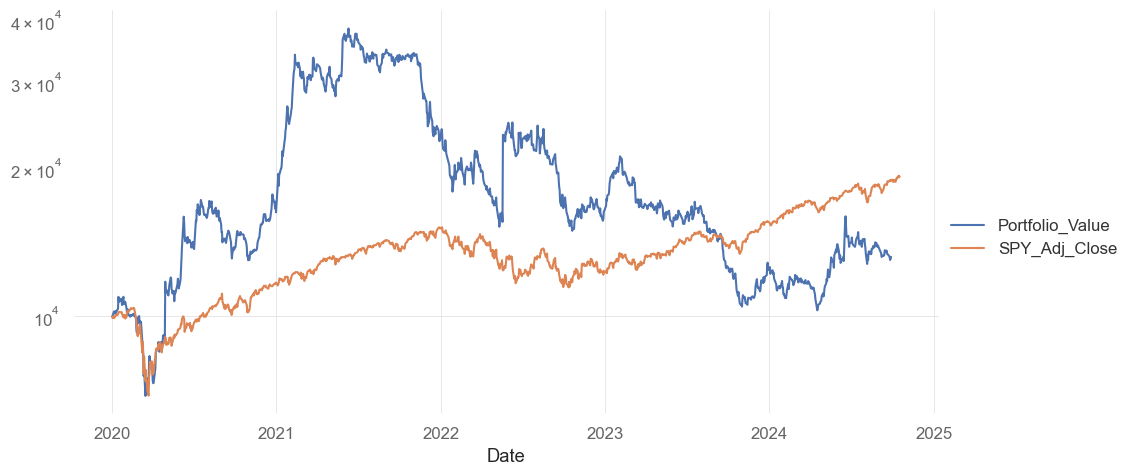

In [65]:
display(sns.relplot(historical_performance_benchmark.loc[:,['Portfolio_Value','SPY_Adj_Close']], kind='line', dashes=False, aspect=2).set(yscale='log'))

In [66]:
historical_performance_benchmark['Portfolio_Returns'] = historical_performance_benchmark['Portfolio_Value'].pct_change()
historical_performance_benchmark['SPY_Returns'] = historical_performance_benchmark['SPY_Adj_Close'].pct_change()
display(historical_performance_benchmark)

C:\Users\matth\AppData\Local\Temp\ipykernel_31708\4183507633.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  historical_performance_benchmark['Portfolio_Returns'] = historical_performance_benchmark['Portfolio_Value'].pct_change()


,Portfolio_Value,SPY_Adj_Close,Portfolio_Returns,SPY_Returns
Date,,,,
2020-01-02,10000.000000,10000.000000,NaN,NaN
2020-01-03,10038.641403,9924.276766,0.003864,-0.007572
2020-01-06,10232.159878,9962.138888,0.019277,0.003815
2020-01-07,10190.254895,9934.126532,-0.004095,-0.002812
2020-01-08,10142.814621,9987.072308,-0.004655,0.005330
...,...,...,...,...
2024-10-10,NaN,19063.981372,0.000000,-0.001750
2024-10-11,NaN,19178.141315,0.000000,0.005988
2024-10-14,NaN,19334.986271,0.000000,0.008178


In [67]:
from portfolio_analytics import make_stats_dataframe
# import pandas as pd
# import quantstats as qs

# def make_stats_dataframe(returns, benchmark_returns, portfolio_name="portfolio", decimals=3):
#     """Outputs a DataFrame of statistics for a single portfolio.

#     Args:
#         returns (dataframe): portfolio; date as the index column, decimal change values from day to day as the value column.
#         benchmark_returns (dataframe): benchmark; date as the index column, decimal change values from day to day as the value column.
#         portfolio_name (str, optional): Name of the portfolio. Defaults to "portfolio".
#         decimals (int, optional): Number of decimal places for the statistics. Defaults to 3.

#     Returns:
#         pd.DataFrame: DataFrame with a single row of statistics for the portfolio.
#     """
#     # Create a dictionary to store the statistics
#     stats = {}

#     # Calculate and store statistics
#     stats["Annualized Return (CAGR)"] = round(qs.stats.cagr(returns) * 100, decimals)
#     stats["Volatility (Standard Deviation)"] = round(qs.stats.volatility(returns) * 100, decimals)
#     stats["Max Drawdown"] = round(qs.stats.max_drawdown(returns) * 100, decimals)
    
#     # Alpha and Beta
#     greeks = qs.stats.greeks(returns, benchmark_returns)
#     stats["Alpha"] = round(greeks['alpha'], decimals)
#     stats["Beta"] = round(greeks['beta'], decimals)
    
#     # Sharpe and Sortino Ratios
#     stats["Sharpe Ratio"] = round(qs.stats.sharpe(returns), decimals)
#     stats["Sortino Ratio"] = round(qs.stats.sortino(returns), decimals)
    
#     # Convert the stats dictionary to a DataFrame
#     stats_df = pd.DataFrame(stats, index=[portfolio_name])
    
#     return stats_df


In [68]:
pd.concat([
        make_stats_dataframe(historical_performance_benchmark.loc[:,'Portfolio_Returns'].dropna(),
                     historical_performance_benchmark.loc[:,'SPY_Returns'].dropna() ),
                make_stats_dataframe(historical_performance_benchmark.loc[:,'SPY_Returns'].dropna(),
                     historical_performance_benchmark.loc[:,'SPY_Returns'].dropna() , portfolio_name='SPY')
],axis=0)#.transpose()

,Annualized Return (CAGR),Volatility (Standard Deviation),Max Drawdown,Alpha,Beta,Sharpe Ratio,Sortino Ratio
portfolio,4.104,48.177,-73.289,0.019,0.915,0.343,0.637
SPY,9.917,21.279,-33.717,0.000,1.000,0.752,1.051


In [69]:
trading_history_obj.add_analytics()

In [70]:
display(trading_history_obj.trades.info())
display(trading_history_obj.trades)

<class 'pandas.core.frame.DataFrame'>
Index: 260 entries, AEMD_2020-01-02 to ATMU_2024-06-14
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Ticker                      260 non-null    object        
 1   Entry_Date                  260 non-null    datetime64[ns]
 2   Entry_Share_Price           260 non-null    float64       
 3   Entry_Trading_Cost          260 non-null    float64       
 4   Shares                      260 non-null    float64       
 5   Exit_Date                   240 non-null    datetime64[ns]
 6   Exit_Share_Price            240 non-null    object        
 7   Exit_Trading_Cost           240 non-null    object        
 8   Days_Held                   240 non-null    float64       
 9   Return                      240 non-null    object        
 10  Percent_Return              240 non-null    object        
 11  Annualized_Percent_Returns  240 non-n

None

,Ticker,Entry_Date,Entry_Share_Price,Entry_Trading_Cost,Shares,Exit_Date,Exit_Share_Price,Exit_Trading_Cost,Days_Held,Return,Percent_Return,Annualized_Percent_Returns,Sector,Industry,Country,Size_Category_Entry
AEMD_2020-01-02,AEMD,2020-01-02,12.500000,0.020,38.0,2020-05-18,13.2,0.02,137.0,26.599993,0.056,0.156235,Health Care,Medical/Dental Instruments,United States,micro
CAPR_2020-01-02,CAPR,2020-01-02,1.230000,0.020,394.0,2020-05-18,5.51,0.02,137.0,1686.320083,3.479675,53.334139,Health Care,Biotechnology: Pharmaceutical Preparations,United States,micro
ALT_2020-01-02,ALT,2020-01-02,1.921000,0.020,252.0,2020-05-18,4.5,0.01,137.0,649.907999,1.34253,8.658898,Health Care,Biotechnology: Pharmaceutical Preparations,United States,micro
PRPO_2020-01-02,PRPO,2020-01-02,39.799999,0.020,12.0,2020-05-18,13.4,0.02,137.0,-316.799995,-0.663317,-0.944994,Industrials,Biotechnology: Laboratory Analytical Instruments,United States,micro
CLDX_2020-01-02,CLDX,2020-01-02,2.250000,0.020,215.0,2020-05-18,2.34,0.02,137.0,19.349982,0.04,0.110148,Health Care,Biotechnology: In Vitro & In Vivo Diagnostic S...,United States,micro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOG_2024-06-14,HOG,2024-06-14,32.520000,0.005,19.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Consumer Discretionary,Motor Vehicles,United States,mid
ALSN_2024-06-14,ALSN,2024-06-14,72.440002,0.005,8.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Consumer Discretionary,Auto Parts:O.E.M.,United States,mid
RUSHB_2024-06-14,RUSHB,2024-06-14,38.119999,0.005,16.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Consumer Discretionary,Retail-Auto Dealers and Gas Stations,United States,mid
AXNX_2024-06-14,AXNX,2024-06-14,67.199997,0.005,9.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Health Care,Medical/Dental Instruments,United States,mid
